In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
df = pd.read_excel("data.xlsx")

In [151]:
df = df[~(df.date_list.isna() & df.date_telematics.isna() & (~df.leader))]

In [152]:
df

,leader,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,True,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,NaT,158.0,NaT,140.26,17.0,3.5
1,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-04,9.0,2024-04-02,3.00,1.0,3.5
2,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-08,5.0,2024-04-08,5.00,1.0,3.5
3,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-09,7.0,2024-04-09,7.00,NaN,3.5
4,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-10,12.0,2024-04-10,12.00,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...
4396,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-28,8.0,2024-04-28,8.00,NaN,5.2
4397,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-30,46.0,2024-04-30,46.00,NaN,5.2
4398,True,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaT,11.0,NaT,0.00,0.0,5.3
4399,False,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-05,3.0,NaT,NaN,9.0,5.3


In [153]:
df['penalty'] = df['penalty'].fillna(1.)
df.loc[df['penalty'] == 0, 'penalty'] = 1.

df['penalty']

0       17.0
1        1.0
2        1.0
3        1.0
4        2.0
        ... 
4396     1.0
4397     1.0
4398     1.0
4399     9.0
4400     1.0
Name: penalty, Length: 4401, dtype: float64

# Графики по штрафам, манере вождения и пробегу

In [154]:
def get_polygons_rate(df_group):
	rate_polygons = df_group[['mileage_list', 'mileage_telematics', 'penalty']].sum()
	rate_polygons = rate_polygons.join(df_group[['driving_style']].mean())
	rate_polygons = rate_polygons.join(df_group[['driving_style']].count().rename(columns={'driving_style': 'cnt'}))

	rate_polygons['mileage_deviation'] = (1 - (rate_polygons['mileage_list'] / rate_polygons['mileage_telematics'])).abs()
	rate_polygons['mileage_deviation_score'] = 1 / (np.e ** rate_polygons['mileage_deviation'])

	rate_polygons['driving_style_score'] = rate_polygons['driving_style'] / 6

	rate_polygons['penalty_score'] = 1 / (rate_polygons['penalty'] / rate_polygons['cnt'])

	rate_polygons['result_score'] = rate_polygons['mileage_deviation_score'] * 0.57 + rate_polygons['penalty_score'] * 0.21 + rate_polygons['driving_style_score'] * 0.21

	return rate_polygons

In [155]:
rate_polygons_group = df[df.leader == True].groupby('polygon')
rate_polygons = get_polygons_rate(rate_polygons_group)

rate_polygons = rate_polygons.reset_index()
rate_polygons

,polygon,mileage_list,mileage_telematics,penalty,driving_style,cnt,mileage_deviation,mileage_deviation_score,driving_style_score,penalty_score,result_score
0,Горьковская дир,163788.27,147695.28,676.0,3.868116,138,0.108961,0.896766,0.644686,0.204142,0.689410
1,Клнг. ДУТСК,27903.42,4618.77,139.0,3.596875,32,5.041310,0.006465,0.599479,0.230216,0.177921
2,Московская ДМ,196578.51,183048.09,733.0,3.342466,146,0.073917,0.928749,0.557078,0.199181,0.688201
3,Окт ДМ,46844.80,48498.36,389.0,3.619753,81,0.034095,0.966480,0.603292,0.208226,0.721312
4,Северная ДМ,275400.14,204838.43,418.0,4.287179,78,0.344475,0.708592,0.714530,0.186603,0.593135


## Манера вождения

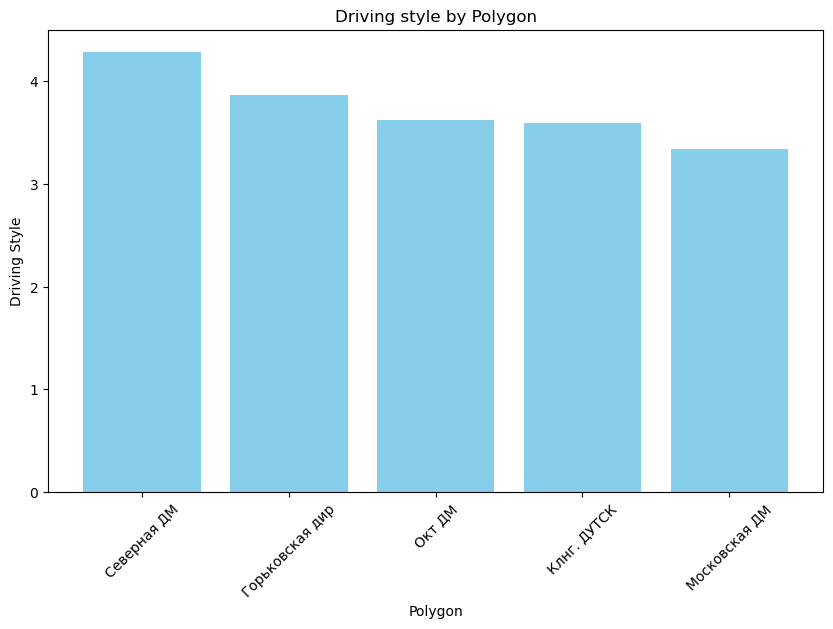

,polygon,driving_style
4,Северная ДМ,4.287179
0,Горьковская дир,3.868116
3,Окт ДМ,3.619753
1,Клнг. ДУТСК,3.596875
2,Московская ДМ,3.342466


In [156]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'driving_style': rate_polygons['driving_style']})
graph1_sorted = graph1.sort_values(by='driving_style', ascending=False)
graph1_sorted

plt.figure(figsize=(10, 6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['driving_style'], color='skyblue')
plt.xlabel('Polygon')
plt.ylabel('Driving Style')
plt.title('Driving style by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

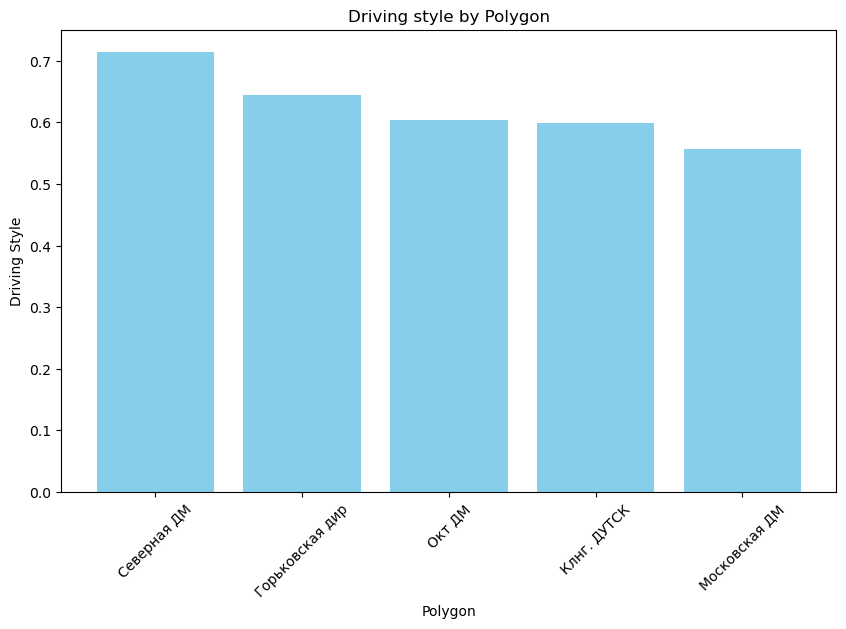

,polygon,driving_style_score
4,Северная ДМ,0.714530
0,Горьковская дир,0.644686
3,Окт ДМ,0.603292
1,Клнг. ДУТСК,0.599479
2,Московская ДМ,0.557078


In [157]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'driving_style_score': rate_polygons['driving_style_score']})
graph1_sorted = graph1.sort_values(by='driving_style_score', ascending=False)
graph1_sorted

plt.figure(figsize=(10, 6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['driving_style_score'], color='skyblue')
plt.xlabel('Polygon')
plt.ylabel('Driving Style')
plt.title('Driving style by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

## Штрафы

In [158]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'penalty': rate_polygons['penalty']})
graph1_sorted = graph1.sort_values(by='penalty')

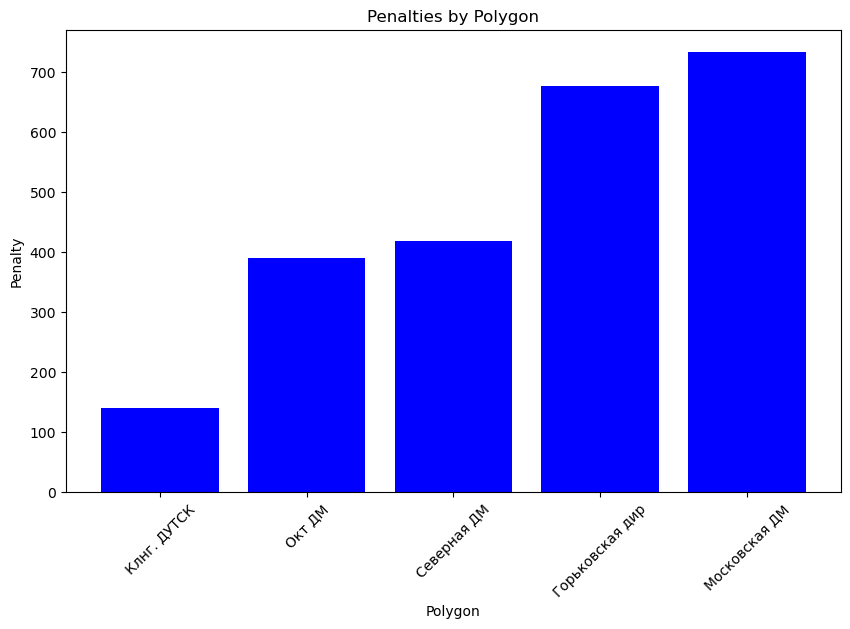

In [159]:
plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['penalty'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Penalty')
plt.title('Penalties by Polygon')
plt.xticks(rotation=45)
plt.show()

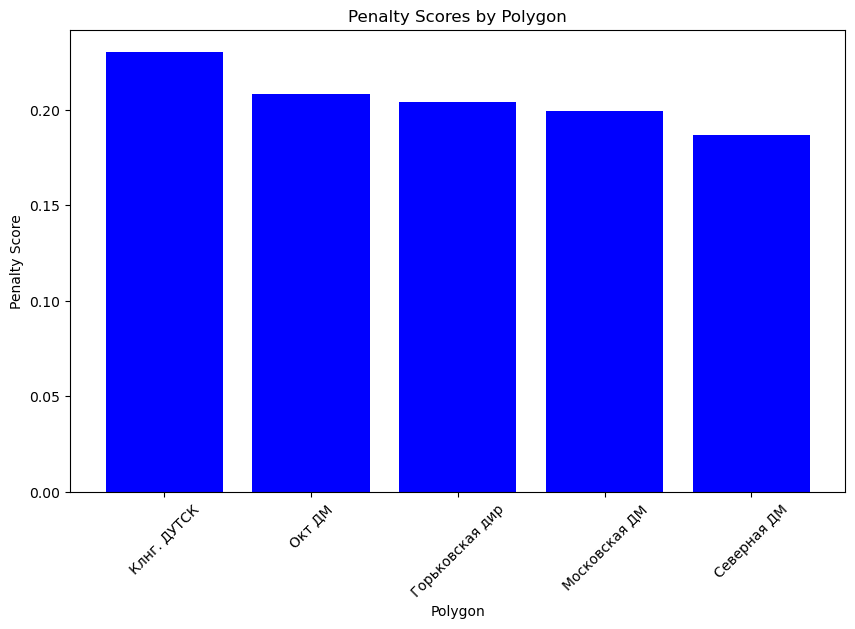

,polygon,res
1,Клнг. ДУТСК,0.230216
3,Окт ДМ,0.208226
0,Горьковская дир,0.204142
2,Московская ДМ,0.199181
4,Северная ДМ,0.186603


In [160]:
res = pd.DataFrame({'polygon': rate_polygons['polygon'], 'res': rate_polygons['penalty_score']})
res_sorted = res.sort_values(by='res', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(res_sorted['polygon'], res_sorted['res'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Penalty Score')
plt.title('Penalty Scores by Polygon')
plt.xticks(rotation=45)
plt.show()

res_sorted

# Пробег

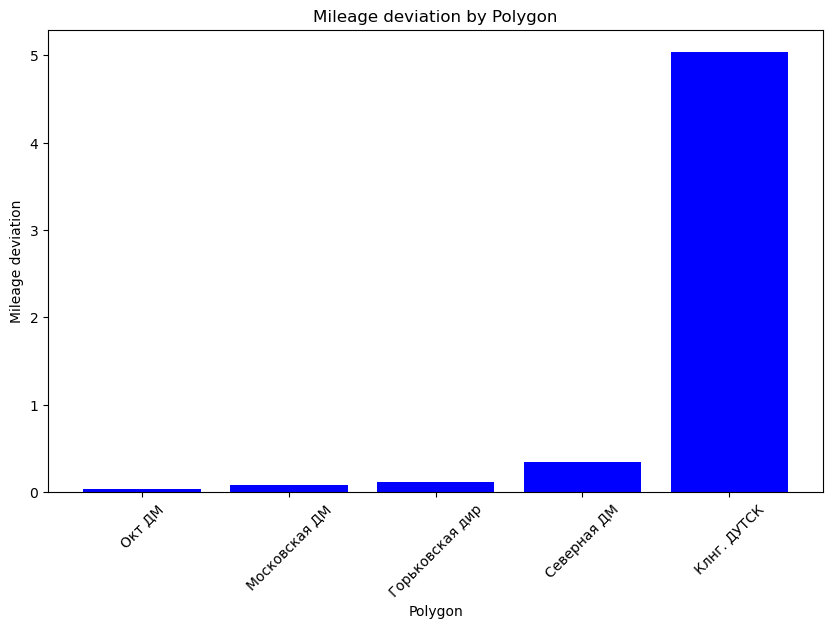

,polygon,mileage_deviation
3,Окт ДМ,0.034095
2,Московская ДМ,0.073917
0,Горьковская дир,0.108961
4,Северная ДМ,0.344475
1,Клнг. ДУТСК,5.041310


In [161]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'mileage_deviation': rate_polygons['mileage_deviation']})
graph1_sorted = graph1.sort_values(by='mileage_deviation')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['mileage_deviation'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Mileage deviation')
plt.title('Mileage deviation by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

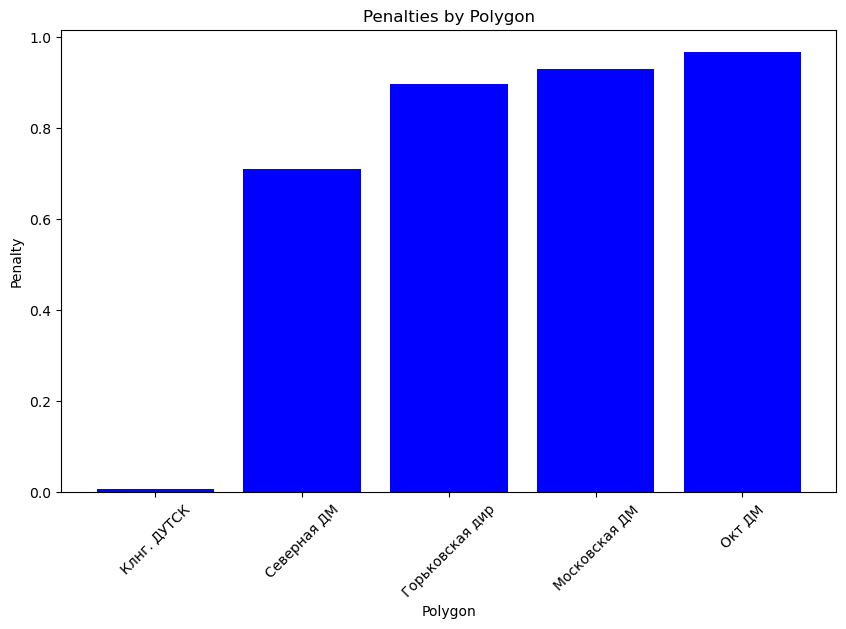

,polygon,mileage_deviation_score
1,Клнг. ДУТСК,0.006465
4,Северная ДМ,0.708592
0,Горьковская дир,0.896766
2,Московская ДМ,0.928749
3,Окт ДМ,0.966480


In [162]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'mileage_deviation_score': rate_polygons['mileage_deviation_score']})
graph1_sorted = graph1.sort_values(by='mileage_deviation_score')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['mileage_deviation_score'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Penalty')
plt.title('Penalties by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

# Конечный скор

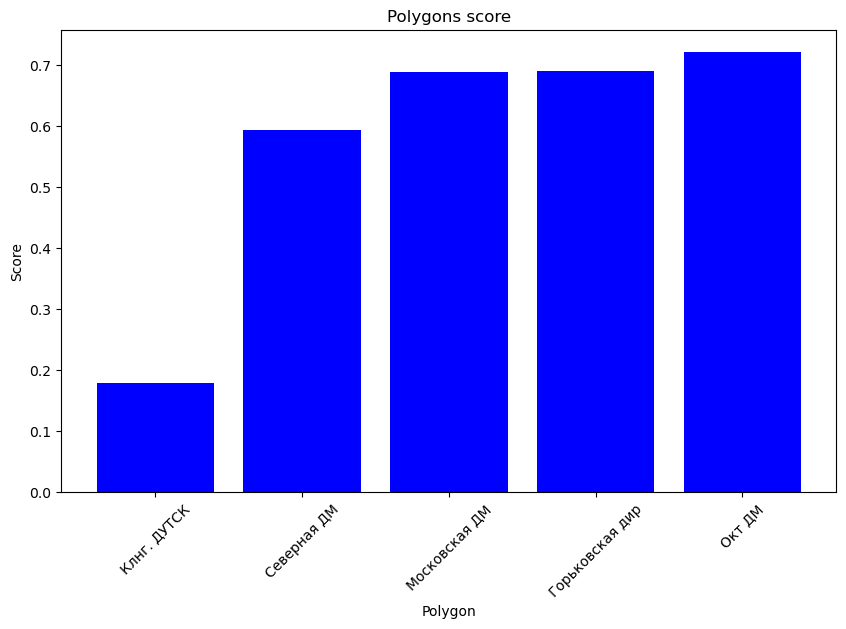

,polygon,result_score
1,Клнг. ДУТСК,0.177921
4,Северная ДМ,0.593135
2,Московская ДМ,0.688201
0,Горьковская дир,0.689410
3,Окт ДМ,0.721312


In [163]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'result_score': rate_polygons['result_score']})
graph1_sorted = graph1.sort_values(by='result_score')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['result_score'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Score')
plt.title('Polygons score')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

# Распределение транспорта

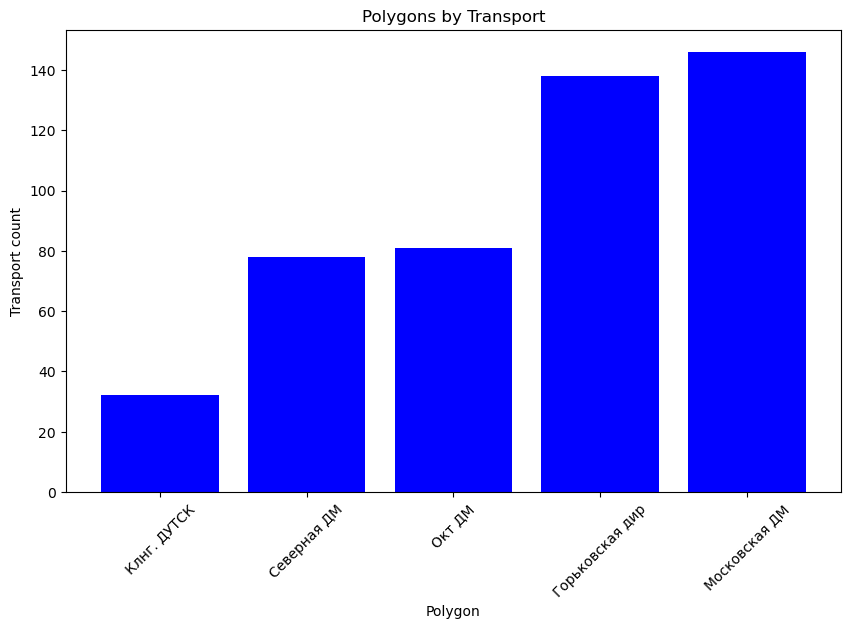

,polygon,cnt
1,Клнг. ДУТСК,32
4,Северная ДМ,78
3,Окт ДМ,81
0,Горьковская дир,138
2,Московская ДМ,146


In [164]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'cnt': rate_polygons['cnt']})
graph1_sorted = graph1.sort_values(by='cnt')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['cnt'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Transport count')
plt.title('Polygons by Transport')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

In [165]:
init_stract = df[df.leader == True].groupby('polygon')[['polygon']].count().rename(columns={'polygon': 'count_car'})
init_stract = init_stract.reset_index()
for elem in df['subpolygon'].unique(): 
    init_stract[elem] = [len(df[(df.leader == True) & (df['subpolygon'] == elem) & (df['polygon'] == i)]) for i in init_stract['polygon'].unique()]
init_stract

,polygon,count_car,ГТС Выборг,Московская механизированная дистанция ОКТ ДМ (МЧ-1),NaN,Калининградская ДМ,МЧ-01 г.Калининград,Московская механизированная дистанция погрузочно-разгрузочных рабо#,Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Орловская механизированная дистанция погрузочно-разгрузочных работ,ДМУ-3,ДМУ-4,ДМУ-2,Котласская механизированная дистанция ПРР и КО,Архангельская механизированная дистанция ПРР и КО
0,Горьковская дир,138,0,0,0,0,0,0,0,0,25,39,74,0,0
1,Клнг. ДУТСК,32,0,0,0,18,14,0,0,0,0,0,0,0,0
2,Московская ДМ,147,0,0,0,0,0,79,27,39,0,0,0,0,0
3,Окт ДМ,81,51,27,0,0,0,0,0,0,0,0,0,0,0
4,Северная ДМ,78,0,0,0,0,0,0,0,0,0,0,0,28,50


In [166]:
init_stract['polygon'].unique()

array(['Горьковская дир', 'Клнг. ДУТСК', 'Московская ДМ', 'Окт ДМ',
       'Северная ДМ'], dtype=object)

In [167]:
df['subpolygon'].unique()

array(['ГТС Выборг',
       'Московская механизированная дистанция ОКТ ДМ (МЧ-1)', nan,
       'Калининградская ДМ', 'МЧ-01 г.Калининград',
       'Московская механизированная дистанция погрузочно-разгрузочных рабо#',
       'Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#',
       'Орловская механизированная дистанция погрузочно-разгрузочных работ',
       'ДМУ-3', 'ДМУ-4', 'ДМУ-2',
       'Котласская механизированная дистанция ПРР и КО',
       'Архангельская механизированная дистанция ПРР и КО'], dtype=object)

In [168]:
data_col_stract = {
    'polygon': [],
    'polygon_count': [],
    'subpolygon': [],
    'subpolygon_count': [],
    'res': [],
}
for i in init_stract['polygon']:
    tmp = init_stract[init_stract['polygon'] == i]
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    for elem in tmp.columns[2:]:
        data_col_stract['polygon'].append(i)
        data_col_stract['polygon_count'].append(tmp['count_car'].values[0])
        data_col_stract['subpolygon'].append(elem)
        data_col_stract['subpolygon_count'].append(tmp[elem].values[0])
        data_col_stract['res'].append(tmp[elem].values[0] / tmp['count_car'].values[0])

data_init_stract = pd.DataFrame(data_col_stract)
data_init_stract = data_init_stract.set_index('subpolygon')

In [169]:
data_init_stract

,polygon,polygon_count,subpolygon_count,res
subpolygon,,,,
ДМУ-3,Горьковская дир,138,25,0.181159
ДМУ-4,Горьковская дир,138,39,0.282609
ДМУ-2,Горьковская дир,138,74,0.536232
Калининградская ДМ,Клнг. ДУТСК,32,18,0.562500
МЧ-01 г.Калининград,Клнг. ДУТСК,32,14,0.437500
Московская механизированная дистанция погрузочно-разгрузочных рабо#,Московская ДМ,147,79,0.537415
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Московская ДМ,147,27,0.183673
Орловская механизированная дистанция погрузочно-разгрузочных работ,Московская ДМ,147,39,0.265306
ГТС Выборг,Окт ДМ,81,51,0.629630


In [170]:
subpolygons_to_polygons = data_init_stract[['polygon']]

In [171]:
rate_subpolygons_group = df[df.leader == True].groupby('subpolygon')
rate_subpolygons = get_polygons_rate(rate_subpolygons_group).drop(columns=['result_score'])
rate_subpolygons = rate_subpolygons.join(data_init_stract.rename(columns={'res': 'subpolygon_cars_deviation'})[['subpolygon_cars_deviation']])

rate_subpolygons['polygon'] = subpolygons_to_polygons.loc[rate_subpolygons.index]

rate_subpolygons['subpolygon_cars_score'] = rate_subpolygons['subpolygon_cars_deviation']

rate_subpolygons['result_score'] = rate_subpolygons['mileage_deviation_score'] * 0.4 + rate_subpolygons['subpolygon_cars_score'] * 0.3 + rate_subpolygons['penalty_score'] * 0.15 + rate_subpolygons['driving_style_score'] * 0.15

rate_subpolygons

,mileage_list,mileage_telematics,penalty,driving_style,cnt,mileage_deviation,mileage_deviation_score,driving_style_score,penalty_score,subpolygon_cars_deviation,polygon,subpolygon_cars_score,result_score
subpolygon,,,,,,,,,,,,,
Архангельская механизированная дистанция ПРР и КО,236594.14,184887.71,316.0,4.428000,50,0.279664,7.560378e-01,0.738000,0.158228,0.641026,Северная ДМ,0.641026,0.629157
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,39128.90,40114.50,187.0,4.511111,27,0.024570,9.757297e-01,0.751852,0.144385,0.183673,Московская ДМ,0.183673,0.579829
ГТС Выборг,20597.68,21350.77,223.0,4.200000,51,0.035272,9.653426e-01,0.700000,0.228700,0.629630,Окт ДМ,0.629630,0.714331
ДМУ-2,115101.77,98184.86,362.0,3.781081,74,0.172297,8.417295e-01,0.630180,0.204420,0.536232,Горьковская дир,0.536232,0.622751
ДМУ-3,17092.50,18736.76,178.0,3.920000,25,0.087756,9.159845e-01,0.653333,0.140449,0.181159,Горьковская дир,0.181159,0.539809
ДМУ-4,31594.00,30773.66,136.0,4.000000,39,0.026657,9.736950e-01,0.666667,0.286765,0.282609,Горьковская дир,0.282609,0.617275
Калининградская ДМ,1388.43,2989.79,61.0,3.322222,18,0.535610,5.853124e-01,0.553704,0.295082,0.562500,Клнг. ДУТСК,0.562500,0.530193
Котласская механизированная дистанция ПРР и КО,38806.00,19950.72,102.0,4.035714,28,0.945093,3.886435e-01,0.672619,0.274510,0.358974,Северная ДМ,0.358974,0.405219
МЧ-01 г.Калининград,26514.99,1628.98,78.0,3.950000,14,15.277051,2.318789e-07,0.658333,0.179487,0.437500,Клнг. ДУТСК,0.437500,0.256923


In [172]:
subpolygons_to_polygons

,polygon
subpolygon,
ДМУ-3,Горьковская дир
ДМУ-4,Горьковская дир
ДМУ-2,Горьковская дир
Калининградская ДМ,Клнг. ДУТСК
МЧ-01 г.Калининград,Клнг. ДУТСК
Московская механизированная дистанция погрузочно-разгрузочных рабо#,Московская ДМ
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Московская ДМ
Орловская механизированная дистанция погрузочно-разгрузочных работ,Московская ДМ
ГТС Выборг,Окт ДМ


In [173]:
rate_subpolygons

,mileage_list,mileage_telematics,penalty,driving_style,cnt,mileage_deviation,mileage_deviation_score,driving_style_score,penalty_score,subpolygon_cars_deviation,polygon,subpolygon_cars_score,result_score
subpolygon,,,,,,,,,,,,,
Архангельская механизированная дистанция ПРР и КО,236594.14,184887.71,316.0,4.428000,50,0.279664,7.560378e-01,0.738000,0.158228,0.641026,Северная ДМ,0.641026,0.629157
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,39128.90,40114.50,187.0,4.511111,27,0.024570,9.757297e-01,0.751852,0.144385,0.183673,Московская ДМ,0.183673,0.579829
ГТС Выборг,20597.68,21350.77,223.0,4.200000,51,0.035272,9.653426e-01,0.700000,0.228700,0.629630,Окт ДМ,0.629630,0.714331
ДМУ-2,115101.77,98184.86,362.0,3.781081,74,0.172297,8.417295e-01,0.630180,0.204420,0.536232,Горьковская дир,0.536232,0.622751
ДМУ-3,17092.50,18736.76,178.0,3.920000,25,0.087756,9.159845e-01,0.653333,0.140449,0.181159,Горьковская дир,0.181159,0.539809
ДМУ-4,31594.00,30773.66,136.0,4.000000,39,0.026657,9.736950e-01,0.666667,0.286765,0.282609,Горьковская дир,0.282609,0.617275
Калининградская ДМ,1388.43,2989.79,61.0,3.322222,18,0.535610,5.853124e-01,0.553704,0.295082,0.562500,Клнг. ДУТСК,0.562500,0.530193
Котласская механизированная дистанция ПРР и КО,38806.00,19950.72,102.0,4.035714,28,0.945093,3.886435e-01,0.672619,0.274510,0.358974,Северная ДМ,0.358974,0.405219
МЧ-01 г.Калининград,26514.99,1628.98,78.0,3.950000,14,15.277051,2.318789e-07,0.658333,0.179487,0.437500,Клнг. ДУТСК,0.437500,0.256923


In [174]:
subpolygons_to_polygons.loc[rate_subpolygons.index]

,polygon
subpolygon,
Архангельская механизированная дистанция ПРР и КО,Северная ДМ
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Московская ДМ
ГТС Выборг,Окт ДМ
ДМУ-2,Горьковская дир
ДМУ-3,Горьковская дир
ДМУ-4,Горьковская дир
Калининградская ДМ,Клнг. ДУТСК
Котласская механизированная дистанция ПРР и КО,Северная ДМ
МЧ-01 г.Калининград,Клнг. ДУТСК


In [175]:
subpolygons_to_polygons.loc[rate_subpolygons.index].values

array([['Северная ДМ'],
       ['Московская ДМ'],
       ['Окт ДМ'],
       ['Горьковская дир'],
       ['Горьковская дир'],
       ['Горьковская дир'],
       ['Клнг. ДУТСК'],
       ['Северная ДМ'],
       ['Клнг. ДУТСК'],
       ['Окт ДМ'],
       ['Московская ДМ'],
       ['Московская ДМ']], dtype=object)

In [176]:
{'subpolygon': rate_subpolygons.index, 'polygon': subpolygons_to_polygons.loc[rate_subpolygons.index], 'result_score': rate_subpolygons['result_score']}

{'subpolygon': Index(['Архангельская механизированная дистанция ПРР и КО',
        'Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#',
        'ГТС Выборг', 'ДМУ-2', 'ДМУ-3', 'ДМУ-4', 'Калининградская ДМ',
        'Котласская механизированная дистанция ПРР и КО', 'МЧ-01 г.Калининград',
        'Московская механизированная дистанция ОКТ ДМ (МЧ-1)',
        'Московская механизированная дистанция погрузочно-разгрузочных рабо#',
        'Орловская механизированная дистанция погрузочно-разгрузочных работ'],
       dtype='object', name='subpolygon'),
 'polygon':                                                             polygon
 subpolygon                                                         
 Архангельская механизированная дистанция ПРР и КО       Северная ДМ
 Брянско-Смоленская механизированная дистанция п...    Московская ДМ
 ГТС Выборг                                                   Окт ДМ
 ДМУ-2                                               Горьковская дир
 ДМУ-

In [177]:
pd.DataFrame({'polygon': subpolygons_to_polygons.loc[rate_subpolygons.index]['polygon']})

,polygon
subpolygon,
Архангельская механизированная дистанция ПРР и КО,Северная ДМ
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Московская ДМ
ГТС Выборг,Окт ДМ
ДМУ-2,Горьковская дир
ДМУ-3,Горьковская дир
ДМУ-4,Горьковская дир
Калининградская ДМ,Клнг. ДУТСК
Котласская механизированная дистанция ПРР и КО,Северная ДМ
МЧ-01 г.Калининград,Клнг. ДУТСК


In [178]:
{'subpolygon': rate_subpolygons.index, 'polygon': subpolygons_to_polygons.loc[rate_subpolygons.index]['polygon'], 'result_score': rate_subpolygons['result_score']}

{'subpolygon': Index(['Архангельская механизированная дистанция ПРР и КО',
        'Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#',
        'ГТС Выборг', 'ДМУ-2', 'ДМУ-3', 'ДМУ-4', 'Калининградская ДМ',
        'Котласская механизированная дистанция ПРР и КО', 'МЧ-01 г.Калининград',
        'Московская механизированная дистанция ОКТ ДМ (МЧ-1)',
        'Московская механизированная дистанция погрузочно-разгрузочных рабо#',
        'Орловская механизированная дистанция погрузочно-разгрузочных работ'],
       dtype='object', name='subpolygon'),
 'polygon': subpolygon
 Архангельская механизированная дистанция ПРР и КО                          Северная ДМ
 Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#      Московская ДМ
 ГТС Выборг                                                                      Окт ДМ
 ДМУ-2                                                                  Горьковская дир
 ДМУ-3                                                 

In [179]:
graph1 = pd.DataFrame({'subpolygon': rate_subpolygons.index, 'polygon': subpolygons_to_polygons.loc[rate_subpolygons.index]['polygon'], 'result_score': rate_subpolygons['result_score']})

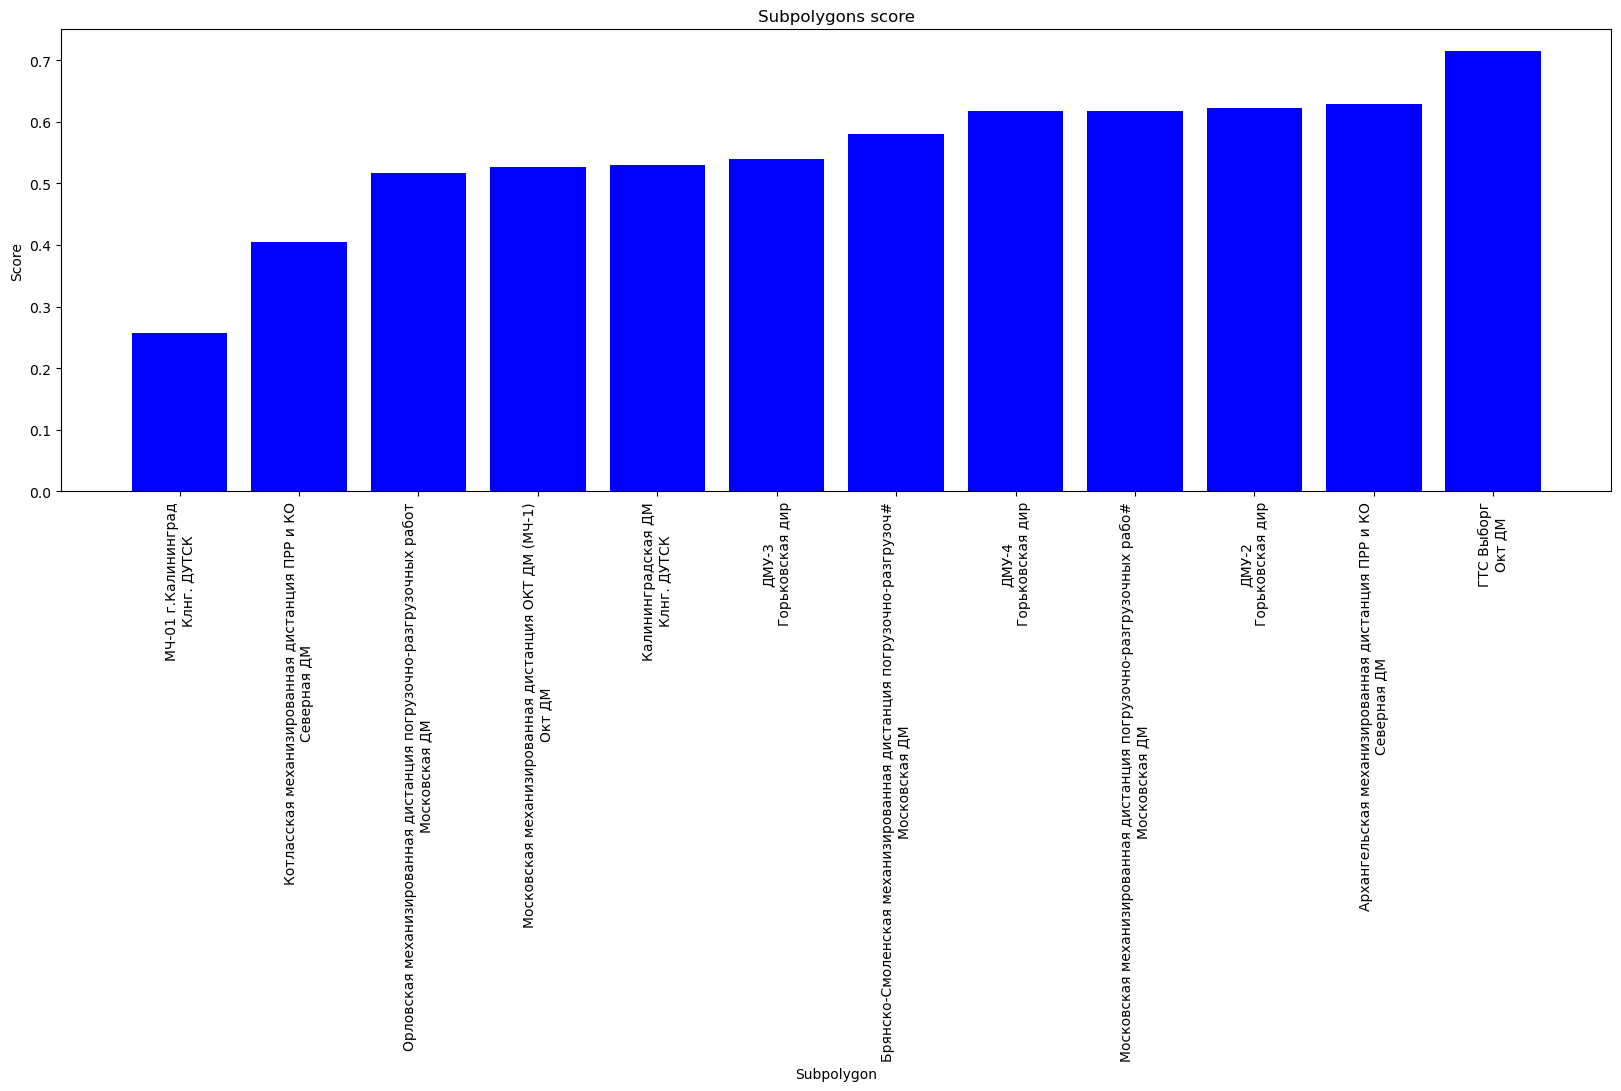

,subpolygon,polygon,result_score
8,МЧ-01 г.Калининград,Клнг. ДУТСК,0.256923
7,Котласская механизированная дистанция ПРР и КО,Северная ДМ,0.405219
11,Орловская механизированная дистанция погрузочн...,Московская ДМ,0.516556
9,Московская механизированная дистанция ОКТ ДМ (...,Окт ДМ,0.527255
6,Калининградская ДМ,Клнг. ДУТСК,0.530193
4,ДМУ-3,Горьковская дир,0.539809
1,Брянско-Смоленская механизированная дистанция ...,Московская ДМ,0.579829
5,ДМУ-4,Горьковская дир,0.617275
10,Московская механизированная дистанция погрузоч...,Московская ДМ,0.618107
3,ДМУ-2,Горьковская дир,0.622751


In [180]:
graph1 = pd.DataFrame({'subpolygon': rate_subpolygons.index, 'polygon': subpolygons_to_polygons.loc[rate_subpolygons.index]['polygon'].values, 'result_score': rate_subpolygons['result_score'].values})
graph1_sorted = graph1.sort_values(by='result_score')

plt.figure(figsize=(20,6))
plt.bar(graph1_sorted['subpolygon'] + '\n' + graph1_sorted['polygon'], graph1_sorted['result_score'], color='blue')
plt.xlabel('Subpolygon')
plt.ylabel('Score')
plt.title('Subpolygons score')
plt.xticks(rotation=90)
plt.show()

graph1_sorted

# Разные аггрегации

In [181]:
df

,leader,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,True,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,NaT,158.0,NaT,140.26,17.0,3.5
1,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-04,9.0,2024-04-02,3.00,1.0,3.5
2,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-08,5.0,2024-04-08,5.00,1.0,3.5
3,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-09,7.0,2024-04-09,7.00,1.0,3.5
4,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-10,12.0,2024-04-10,12.00,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...
4396,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-28,8.0,2024-04-28,8.00,1.0,5.2
4397,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-30,46.0,2024-04-30,46.00,1.0,5.2
4398,True,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaT,11.0,NaT,0.00,1.0,5.3
4399,False,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-05,3.0,NaT,NaN,9.0,5.3


In [182]:
def collect_groups_by_date(df: pd.DataFrame):
	df = df.copy()
	tdf = df[df.leader == False].groupby(['polygon', 'date'])[['penalty', 'mileage_list', 'mileage_telematics']].sum()
	tdf = tdf.join(df[df.leader == False].groupby(['polygon', 'date'])[['driving_style']].mean())

	return tdf

In [183]:
poldatel_gb = collect_groups_by_date(df.rename(columns={'date_list': 'date'}))
poldatet_gb = collect_groups_by_date(df.rename(columns={'date_telematics': 'date'}))

In [184]:
poldate_data = poldatel_gb.join(poldatet_gb, on=['polygon', 'date'], lsuffix='_list', rsuffix='_telematics')

In [185]:
poldate_data['penalty_error'] = (poldate_data['penalty_list'] - poldate_data['penalty_telematics']) ** 2
poldate_data['driving_style_error'] = (poldate_data['driving_style_list'] - poldate_data['driving_style_telematics']) ** 2
poldate_data['mileage_error_list'] = (poldate_data['mileage_list_list'] - poldate_data['mileage_telematics_list']) ** 2
poldate_data['mileage_error_telematics'] = (poldate_data['mileage_list_telematics'] - poldate_data['mileage_telematics_telematics']) ** 2

In [186]:
poldate_data

penalty_list  mileage_list_list  \
polygon         date                                          
Горьковская дир 2024-04-01          26.0            8103.41   
                2024-04-02          10.0            3443.00   
                2024-04-03          26.0            6711.00   
                2024-04-04          14.0            5093.00   
                2024-04-05          18.0            5025.00   
...                                  ...                ...   
Северная ДМ     2024-04-26          32.0           10237.30   
                2024-04-27          17.0            3452.00   
                2024-04-28          21.0            8977.00   
                2024-04-29          15.0            6632.00   
                2024-04-30          16.0            6086.00   

                            mileage_telematics_list  driving_style_list  \
polygon         date                                                      
Горьковская дир 2024-04-01                  4871.00            4.940000   
                2024-04-02                  1730.00            4.900000   
                2024-04-03                  3393.00            5.030769   
                2024-04-04                  3076.00            5.178571   
                2024-04-05                  2478.00            5.133333   
...                                             ...                 ...   
Северная ДМ     2024-04-26                  5280.72            5.106250   
                2024-04-27                  2501.65            5.223529   
                2024-04-28                  4338.00            5.085714   
                2024-04-29                  4351.00            5.120000   
                2024-04-30                  3313.00            5.125000   

                            penalty_telematics  mileage_list_telematics  \
polygon         date                                                      
Горьковская дир 2024-04-01                40.0                  4331.00   
                2024-04-02                10.0                  1730.00   
                2024-04-03                26.0                  2685.00   
                2024-04-04                19.0                  3833.00   
                2024-04-05                21.0                  2823.00   
...                                        ...                      ...   
Северная ДМ     2024-04-26                21.0                  4468.58   
                2024-04-27                10.0                  2497.00   
                2024-04-28                13.0                  4622.00   
                2024-04-29                 9.0                  4422.00   
                2024-04-30                14.0                  2845.00   

                            mileage_telematics_telematics  \
polygon         date                                        
Горьковская дир 2024-04-01                        8768.20   
                2024-04-02                        1957.00   
                2024-04-03                        6944.00   
                2024-04-04                        7089.00   
                2024-04-05                        4045.00   
...                                                   ...   
Северная ДМ     2024-04-26                        6621.72   
                2024-04-27                        3452.65   
                2024-04-28                        5281.00   
                2024-04-29                        4362.00   
                2024-04-30                        4433.00   

                            driving_style_telematics  penalty_error  \
polygon         date                                                  
Горьковская дир 2024-04-01                  4.870270          196.0   
                2024-04-02                  4.960000            0.0   
                2024-04-03                  4.911538            0.0   
                2024-04-04                  5.157895           25.0   
                2024-04-05          

In [187]:
agg_1 = poldate_data.loc['Горьковская дир']

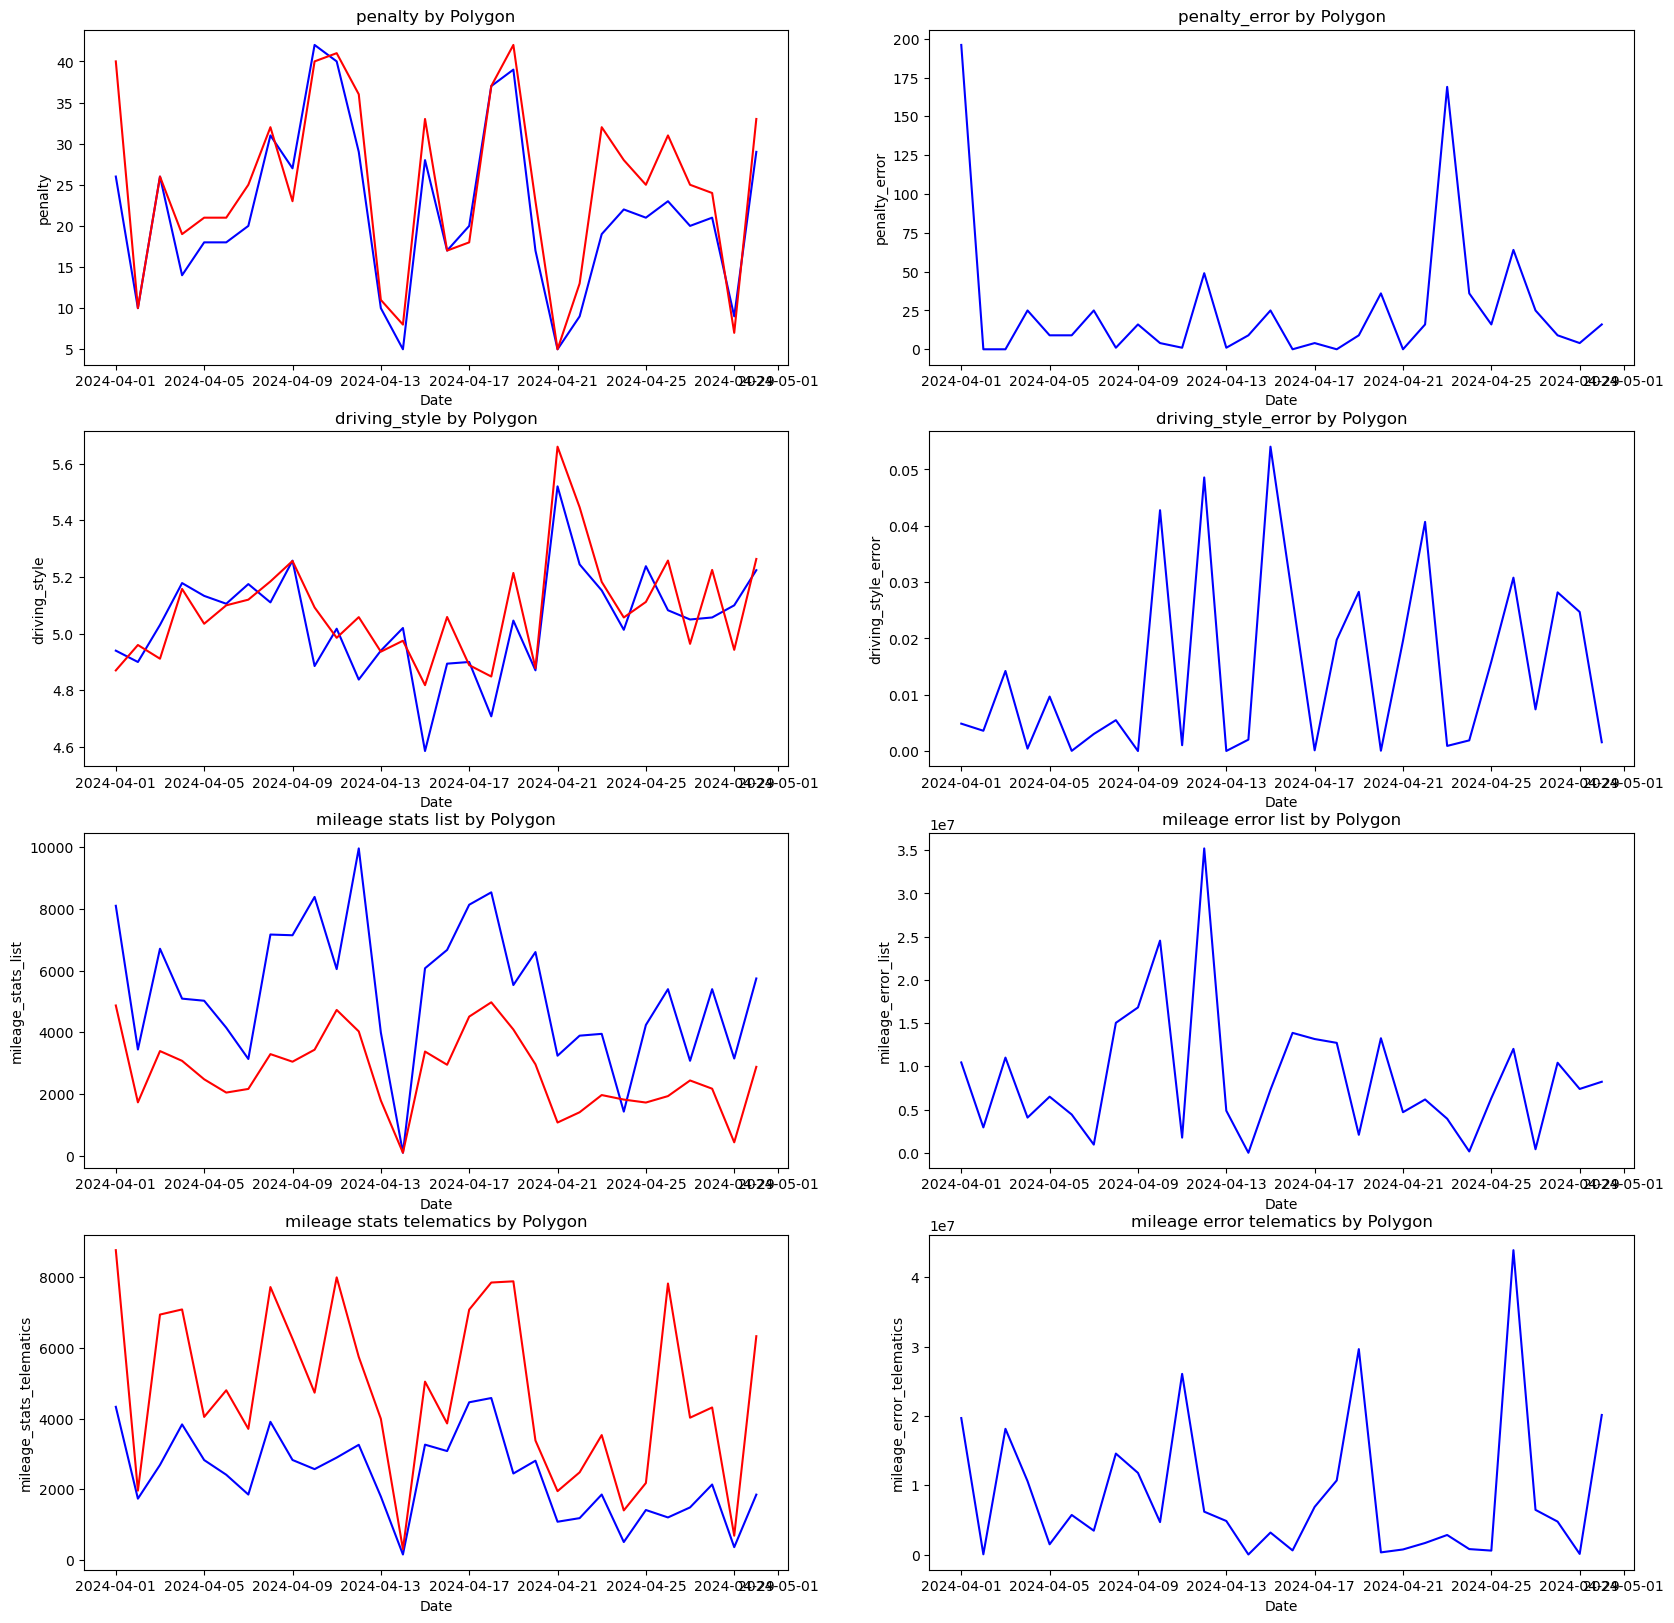

In [188]:
cols = ['penalty', 'penalty_error', 'driving_style', 'driving_style_error']

fig, axs = plt.subplots(4, 2, figsize = (20, 20))

i = 0
		
for axx in axs[:2]:
	ax = axx[0]
	ax.plot(agg_1.index, agg_1[cols[i]+'_list'], color='blue')
	ax.plot(agg_1.index, agg_1[cols[i]+'_telematics'], color='red')
	ax.set_ylabel(cols[i])
	ax.set_xlabel('Date')
	ax.set_title(cols[i] + ' by Polygon')

	i += 1

	ax = axx[1]
	ax.plot(agg_1.index, agg_1[cols[i]], color='blue')
	ax.set_ylabel(cols[i])
	ax.set_xlabel('Date')
	ax.set_title(cols[i] + ' by Polygon')



	i += 1


ax = axs[2][0]
ax.plot(agg_1.index, agg_1['mileage_list_list'], color='blue')
ax.plot(agg_1.index, agg_1['mileage_telematics_list'], color='red')
ax.set_ylabel('mileage_stats_list')
ax.set_xlabel('Date')
ax.set_title('mileage stats list by Polygon')

ax = axs[2][1]
ax.plot(agg_1.index, agg_1['mileage_error_list'], color='blue')
ax.set_ylabel('mileage_error_list')
ax.set_xlabel('Date')
ax.set_title('mileage error list by Polygon')

i+= 1

ax = axs[3][0]
ax.plot(agg_1.index, agg_1['mileage_list_telematics'], color='blue')
ax.plot(agg_1.index, agg_1['mileage_telematics_telematics'], color='red')
ax.set_ylabel('mileage_stats_telematics')
ax.set_xlabel('Date')
ax.set_title('mileage stats telematics by Polygon')

ax = axs[3][1]
ax.plot(agg_1.index, agg_1['mileage_error_telematics'], color='blue')
ax.set_ylabel('mileage_error_telematics')
ax.set_xlabel('Date')
ax.set_title('mileage error telematics by Polygon')


plt.show()

# Смотрим на еще больше данных

### Проверка машин на наличие устройства телематики и на моменты, когда водитель не поехал по маршутному листу

In [189]:
# Если в списках дата есть, а в телематике нет - либо сломана телематика, либо никто не поехал на задание
telematics_leak_state = (df.leader == False) & (df.date_telematics.isna())
telematics_unleak_state = (df.leader == False) & (~df.date_telematics.isna())
telematics_leak = df[telematics_leak_state]
telematics_unleak = df[telematics_unleak_state]


telematics_leak_group = telematics_leak[['subpolygon', 'id', 'leader', 'penalty']].groupby(['subpolygon', 'id'])
telematics_leak_idxs = telematics_leak_group[['leader']].count().rename(columns={'leader': 'count'})
telematics_leak_idxs = telematics_leak_idxs.join(telematics_leak_group[['penalty']].sum())

telematics_unleak_group = telematics_unleak[['subpolygon', 'id', 'leader', 'penalty']].groupby(['subpolygon', 'id'])
telematics_unleak_idxs = telematics_unleak_group[['leader']].count().rename(columns={'leader': 'count'})
telematics_unleak_idxs = telematics_unleak_idxs.join(telematics_unleak_group[['penalty']].sum())

has_telematics_idxs = np.intersect1d(telematics_leak_idxs.index, telematics_unleak_idxs.index)
has_telematics = telematics_leak_idxs.loc[has_telematics_idxs].join(telematics_unleak_idxs.loc[has_telematics_idxs], lsuffix='_leaked', rsuffix='_fixed')
no_telematics = telematics_leak_idxs[~telematics_leak_idxs.index.isin(has_telematics_idxs)]

In [190]:
telematics_leak_idxs

count  penalty
subpolygon                                         id                       
Архангельская механизированная дистанция ПРР и КО  0073МА11       2      2.0
                                                   0940ХР76       3      3.0
                                                   К954СО09       2      2.0
                                                   М777КХ07       2     10.0
                                                   М900ЕХ07      11     11.0
...                                                             ...      ...
Орловская механизированная дистанция погрузочно... 6906ОН57       5      5.0
                                                   7011ОУ57       7      7.0
                                                   М059ОВ177     29     29.0
                                                   Т033ТТ197     28     43.0
                                                   Х494КР177      6      6.0

[119 rows x 2 columns]

In [191]:
no_telematics

count  penalty
subpolygon                                         id                       
Архангельская механизированная дистанция ПРР и КО  0073МА11       2      2.0
                                                   0940ХР76       3      3.0
                                                   К954СО09       2      2.0
                                                   М777КХ07       2     10.0
                                                   М900ЕХ07      11     11.0
...                                                             ...      ...
Орловская механизированная дистанция погрузочно... 6906ОН57       5      5.0
                                                   7011ОУ57       7      7.0
                                                   М059ОВ177     29     29.0
                                                   Т033ТТ197     28     43.0
                                                   Х494КР177      6      6.0

[96 rows x 2 columns]

In [192]:
has_telematics

count_leaked  \
subpolygon                                         id                       
Архангельская механизированная дистанция ПРР и КО  О644НМ07            28   
                                                   О670НМ07             9   
                                                   Р059РВ07            11   
                                                   Р065ХН07            23   
                                                   С156ХУ07            28   
                                                   С607ХУ07            20   
                                                   У415РМ07            26   
Брянско-Смоленская механизированная дистанция п... 1473НХ30             1   
                                                   9444ВУ77            14   
ГТС Выборг                                         0061РХ70             2   
                                                   6346ТА69             6   
ДМУ-2                                              5604УА01             3   
                                                   9996НН50             1   
Калининградская ДМ                                 0900КН39             5   
Котласская механизированная дистанция ПРР и КО     5010МА11             1   
                                                   М014МО07            28   
                                                   М063МО07             8   
                                                   Р500МВ07             4   
                                                   У375ТВ07            18   
                                                   У400ХР07             1   
                                                   Х517АР65             5   
Московская механизированная дистанция погрузочн... 9449ВУ77            28   
                                                   Б/Н                 21   

                                                             penalty_leaked  \
subpolygon                                         id                         
Архангельская механизированная дистанция ПРР и КО  О644НМ07            28.0   
                                                   О670НМ07             9.0   
                                                   Р059РВ07            11.0   
                                                   Р065ХН07            23.0   
                                                   С156ХУ07            28.0   
                                                   С607ХУ07            20.0   
                                                   У415РМ07            26.0   
Брянско-Смоленская механизированная дистанция п... 1473НХ30             1.0   
                                                   9444ВУ77            14.0   
ГТС Выборг                                         0061РХ70             4.0   
                                                   6346ТА69             6.0   
ДМУ-2                                              5604УА01             3.0   
                                                   9996НН50             1.0   
Калининградская ДМ                                 0900КН39             6.0   
Котласская механизированная дистанция ПРР и КО     5010МА11             1.0   
                                                   М014МО07            28.0   
                                                   М063МО07             8.0   
                                                   Р500МВ07             4.0   
                                                   У375ТВ07            18.0   
                                                   У400ХР07             1.0   
                                                   Х517АР65             5.0   
Московская механизированная дистанция погрузочн... 9449ВУ77            28.0   
                                                   Б/Н                 21.0   

                                                             count_fixed  \
subpolygon                                         id                      
Арханге

In [193]:
no_telematics

count  penalty
subpolygon                                         id                       
Архангельская механизированная дистанция ПРР и КО  0073МА11       2      2.0
                                                   0940ХР76       3      3.0
                                                   К954СО09       2      2.0
                                                   М777КХ07       2     10.0
                                                   М900ЕХ07      11     11.0
...                                                             ...      ...
Орловская механизированная дистанция погрузочно... 6906ОН57       5      5.0
                                                   7011ОУ57       7      7.0
                                                   М059ОВ177     29     29.0
                                                   Т033ТТ197     28     43.0
                                                   Х494КР177      6      6.0

[96 rows x 2 columns]

### Случаи использования машины без учёта в списках

In [194]:
# Если данные есть в телематике, но нет в листе, водитель использовал машину в своих интересах или списки были утеряны.
list_leak_state = (df.leader == False) & (df['date_list'].isna())

list_leak = df[list_leak_state]
list_leak_group = list_leak.groupby(['subpolygon', 'id'])

list_leak_view = list_leak_group[['leader']].count()
list_leak_view = list_leak_view.join(list_leak_group[['mileage_telematics', 'penalty']].sum())

In [195]:
list_leak_view

leader  \
subpolygon                                         id                  
Архангельская механизированная дистанция ПРР и КО  0003ВН74        3   
                                                   0030ХН76        4   
                                                   0050ОА04        3   
                                                   0590ЕА30       14   
                                                   0600АР00        3   
...                                                              ...   
Орловская механизированная дистанция погрузочно... 9573ВС77        4   
                                                   9590ВС77        3   
                                                   9591ВС77        6   
                                                   А565ВС177       1   
                                                   Х905ХО197       2   

                                                              mileage_telematics  \
subpolygon                                         id                              
Архангельская механизированная дистанция ПРР и КО  0003ВН74               204.36   
                                                   0030ХН76              1665.00   
                                                   0050ОА04                23.20   
                                                   0590ЕА30              1304.00   
                                                   0600АР00               576.00   
...                                                                          ...   
Орловская механизированная дистанция погрузочно... 9573ВС77               124.12   
                                                   9590ВС77               154.10   
                                                   9591ВС77               512.30   
                                                   А565ВС177                0.33   
                                                   Х905ХО197              185.00   

                                                              penalty  
subpolygon                                         id                  
Архангельская механизированная дистанция ПРР и КО  0003ВН74       3.0  
                                                   0030ХН76       4.0  
                                                   0050ОА04       3.0  
                                                   0590ЕА30      14.0  
                                                   0600АР00       3.0  
...                                                               ...  
Орловская механизированная дистанция погрузочно... 9573ВС77       4.0  
                                                   9590ВС77       5.0  
                                                   9591ВС77       6.0  
                                                   А565ВС177      1.0  
                                                   Х905ХО197      2.0  

[123 rows x 3 columns]